# Plant Disease Prediction

## Importing Dataset

Dataset Link: https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset

## Importing libraries

In [2]:
import os
import csv
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy
import seaborn as sns
from sklearn.model_selection import train_test_split

## Data Preprocessing

### Training Image preprocessing

In [ ]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
tf.config.list_physical_devices('GPU')

In [ ]:
# Directory path
base_dir = 'CottonWeedID15'

# List of directories inside the base directory
directories = ['Crabgrass', 'PalmerAmaranth', 'Ragweed', 'Waterhemp']

# Output CSV file path
output_csv = 'file_mapping.csv'

# Open CSV file for writing
with open(output_csv, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(['Directory', 'Filename'])  # Header row

    # Iterate through each directory
    for directory in directories:
        dir_path = os.path.join(base_dir, directory)
        
        # Iterate through files in the directory
        for filename in os.listdir(dir_path):
            csv_writer.writerow([directory, filename])

In [ ]:
# Define paths
image_folder = '/Users/srivanthdoddala/Downloads/images'
file_mapping = '/Users/srivanthdoddala/Downloads/file_mapping.csv'

# Read CSV file
df = pd.read_csv(file_mapping)

# Train Test Split
training_set, validation_set = train_test_split(df, test_size=0.2)

In [ ]:
# Function to load images and labels
def load_image(image_name, label):
    image_path = tf.strings.join([image_folder, '/', image_name])  # Join paths within TensorFlow context
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image, label

In [ ]:
# Create TensorFlow datasets
training_set = tf.data.Dataset.from_tensor_slices((training_set['Filename'].values, training_set['Directory'].values))
training_set = training_set.map(load_image)

validation_set = tf.data.Dataset.from_tensor_slices((validation_set['Filename'].values, validation_set['Directory'].values))
validation_set = validation_set.map(load_image)

# Batch and prefetch the datasets
batch_size = 32
training_set = training_set.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_set = validation_set.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
for batch in training_set.take(1):
    images, labels = batch
    print("Batch shape:", images.shape)

In [ ]:
# Visualize some images
data_iterator = iter(training_set)
batch = next(data_iterator)
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.numpy())
    ax[idx].title.set_text(batch[1][idx].numpy())

### Validation Image Preprocessing

#### To avoid Overshooting Loss function
1. Choose small learning rate default 0.001 here we have taken 0.0001
2. There may be chance of underfitting so increase number of neuron
3. Add more Convolutional Layer to extract more feature from images there may be possibilty that model unable to capture relevant feature or model is confusing due to lack of feature so feed with more feature

## Building Model

In [242]:
cnn = tf.keras.models.Sequential()

### Building Convolution Layer

In [243]:
cnn.add(tf.keras.layers.Conv2D(filters=32,kernel_size=3,padding='same',activation='relu',input_shape=[128,128,3]))
cnn.add(tf.keras.layers.Conv2D(filters=32,kernel_size=3,activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2))

In [244]:
cnn.add(tf.keras.layers.Conv2D(filters=64,kernel_size=3,padding='same',activation='relu'))
cnn.add(tf.keras.layers.Conv2D(filters=64,kernel_size=3,activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2))

In [245]:
cnn.add(tf.keras.layers.Conv2D(filters=128,kernel_size=3,padding='same',activation='relu'))
cnn.add(tf.keras.layers.Conv2D(filters=128,kernel_size=3,activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2))

In [246]:
cnn.add(tf.keras.layers.Conv2D(filters=256,kernel_size=3,padding='same',activation='relu'))
cnn.add(tf.keras.layers.Conv2D(filters=256,kernel_size=3,activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2))

In [247]:
cnn.add(tf.keras.layers.Conv2D(filters=512,kernel_size=3,padding='same',activation='relu'))
cnn.add(tf.keras.layers.Conv2D(filters=512,kernel_size=3,activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2))

In [248]:
cnn.add(tf.keras.layers.Dropout(0.25))

In [249]:
cnn.add(tf.keras.layers.Flatten())

In [250]:
cnn.add(tf.keras.layers.Dense(units=1500,activation='relu'))

In [251]:
cnn.add(tf.keras.layers.Dropout(0.4)) #To avoid overfitting

In [252]:
#Output Layer
cnn.add(tf.keras.layers.Dense(units=4,activation='softmax'))

### Compiling and Training Phase

In [253]:
cnn.compile(optimizer=tf.keras.optimizers.legacy.Adam(
    learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
training_history = cnn.fit(x=training_set,validation_data=validation_set,epochs=10)

## Evaluating Model

In [ ]:
#Training set Accuracy
train_loss, train_acc = cnn.evaluate(training_set)
print('Training accuracy:', train_acc)

In [ ]:
#Validation set Accuracy
val_loss, val_acc = cnn.evaluate(validation_set)
print('Validation accuracy:', val_acc)

### Saving Model

In [ ]:
cnn.save('/Users/srivanthdoddala/Downloads/my_model')

## Accuracy Visualization

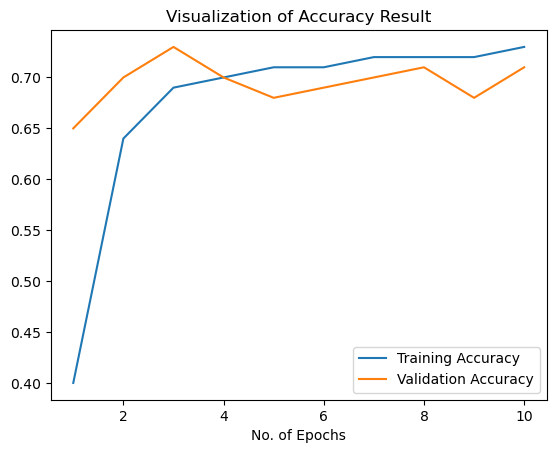

In [270]:
epochs = [i for i in range(1,11)]
plt.plot(epochs,training_history.history['accuracy'],label='Training Accuracy')
plt.plot(epochs,training_history.history['val_accuracy'],label='Validation Accuracy')
plt.xlabel('No. of Epochs')
plt.title('Visualization of Accuracy Result')
plt.legend()
plt.show()

## Some other metrics for model evaluation

In [ ]:
y_pred = cnn.predict(validation_set)
predicted_categories = tf.argmax(y_pred, axis=1)

In [405]:
true_categories = tf.concat([y for x, y in test_set], axis=0)
Y_true = tf.argmax(true_categories, axis=1)

In [408]:
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(Y_true,predicted_categories)

### Confusion Matrix Visualization

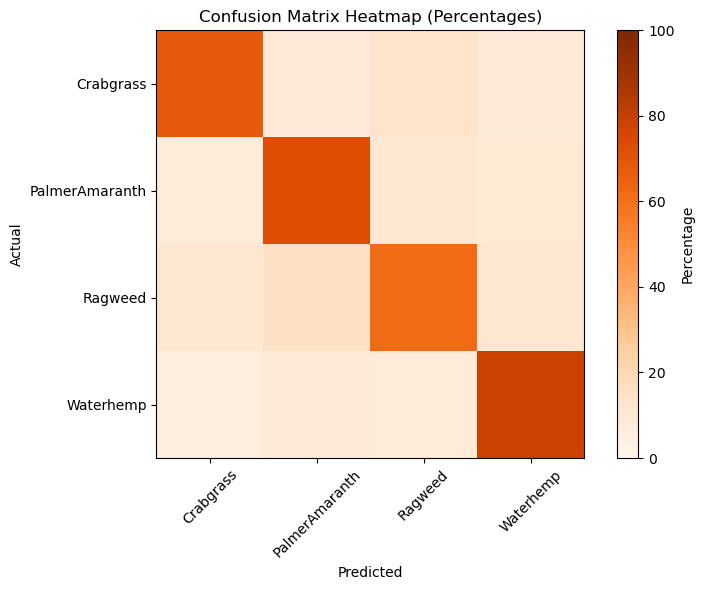

In [409]:
plt.figure(figsize=(40, 40))
sns.heatmap(cm,annot=True,annot_kws={"size": 10})

plt.xlabel('Predicted Class',fontsize = 20)
plt.ylabel('Actual Class',fontsize = 20)
plt.title('Plant Disease Prediction Confusion Matrix',fontsize = 25)
plt.show()